In [1]:
%cd ..

/Users/pedrobedmar/GoogleDrive/MASTER_BIG_DATA/tfm/code


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from etl.esios.provider import ESIOSDataProvider
import lab.functions as func

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

SEED=0
np.random.seed(SEED)

In [3]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [5]:
esios_provider = ESIOSDataProvider()
esios_tickers = esios_provider.get_tickers()
print(esios_tickers)

['DEMANDA_REAL', 'GENERACIÓN_MEDIDA_TOTAL', 'GENERACIÓN_MEDIDA_EÓLICA', 'GENERACIÓN_MEDIDA_HIDRÁULICA', 'GENERACIÓN_MEDIDA_NUCLEAR', 'GENERACIÓN_MEDIDA_SOLAR', 'GENERACIÓN_MEDIDA_CICLO_COMBINADO', 'GENERACIÓN_MEDIDA_CARBÓN', 'PRECIO_MERCADO_SPOT_DIARIO']


In [6]:
forecasting_horizon = 168

nb_windows = 15
step_size = 191

lags = [2, 12, 23, 24, 36, 71, 72, 167, 168]
date_features = ["hour", "day", "day_of_week"]

regressor_list = [KNeighborsRegressor(), RandomForestRegressor(random_state=SEED, n_jobs=-1),
                      GradientBoostingRegressor(random_state=SEED)]
regressor_str_list = ["KNeighborsRegressor", "RandomForestRegressor", "GradientBoostingRegressor"]
save_path="lab/models_skforecast/hourly/"

In [7]:
def load_and_preprocess_daily_data(start_index, end_index, date_features):
    index_type = "DatetimeIndex"
    esios_spot = esios_provider.get_series("PRECIO_MERCADO_SPOT_DIARIO", freq="H", index_type=index_type, start_index=start_index, end_index=end_index)
    esios_df = esios_provider.get_all_series(freq="H", index_type=index_type, start_index=start_index, end_index=end_index)

    X = esios_df.drop(['PRECIO_MERCADO_SPOT_DIARIO', 'GENERACIÓN_MEDIDA_TOTAL'], axis=1)
    lags = []

    df_date_features = func.add_date_features(esios_spot, X, lags, 1, date_features)

    data_train = df_date_features.iloc[:-forecasting_horizon, :].copy()
    data_test = df_date_features.iloc[-forecasting_horizon:, :].copy()

    initial_window_length = len(data_train) - step_size*(nb_windows-1)

    return data_train, data_test, initial_window_length

## Prepandemic

In [15]:
data_train, data_test, initial_window_length = load_and_preprocess_daily_data(start_index="2018-10-01 00:00", end_index="2019-03-31 23:59", date_features=date_features)
print(initial_window_length)

1526


In [ ]:
cv_results_df_summary = func.crossval_model_skforecast(data_train, regressor_list, regressor_str_list, initial_window_length, nb_windows, step_size, lags, date_features, forecasting_horizon)

In [9]:
cv_results_df_summary = cv_results_df_summary.sort_values("mean_mase")
cv_results_df_summary

model  mean_mase  mean_mae  modelling_time
1      RandomForestRegressor   1.196231  2.814613      192.235416
2  GradientBoostingRegressor   1.264396  2.971009      113.174345
0        KNeighborsRegressor   1.918610  4.496688       97.518227

In [10]:
save_name="hourly_pre.pkl"
os.makedirs(save_path, exist_ok=True)
cv_results_df_summary.to_pickle(save_path + save_name)

In [18]:
save_name="hourly_pre.pkl"
cv_results_df_summary = pd.read_pickle(save_path+save_name)

### Final model

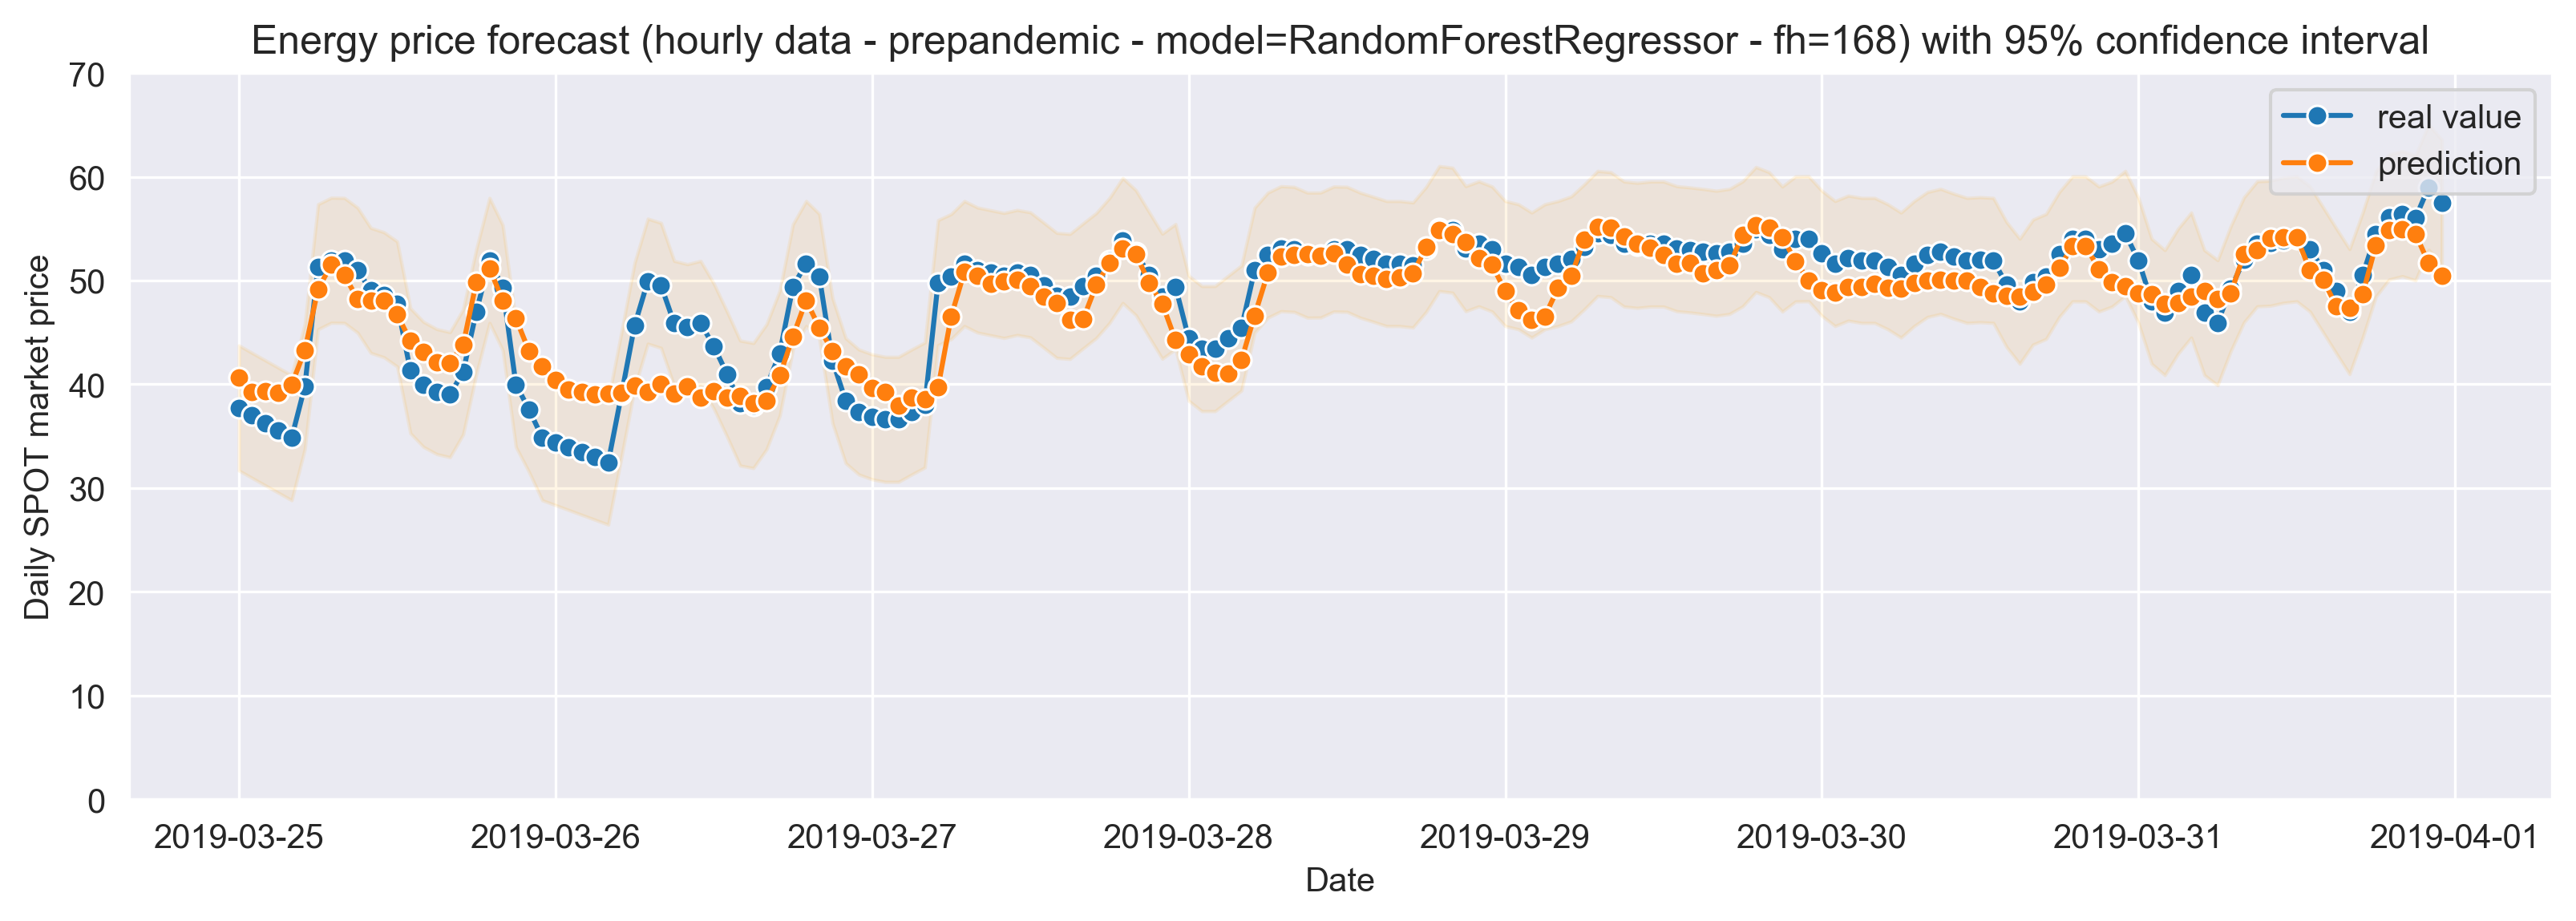

In [19]:
best_model_string = cv_results_df_summary.iloc[0, 0]
best_model = regressor_list[regressor_str_list.index(best_model_string)]
plot_lim = [0,70]
plot_title = f"Energy price forecast (hourly data - prepandemic - model={best_model_string} - fh={forecasting_horizon}) with 95% confidence interval"

func.final_model_skforecast(data_train, data_test, best_model, best_model_string, lags, date_features, forecasting_horizon, cv_results_df_summary, plot_lim, plot_title)

## Postpandemic

In [20]:
data_train, data_test, initial_window_length = load_and_preprocess_daily_data(start_index="2022-10-01 00:00", end_index="2023-03-31 23:59", date_features=date_features)
print(initial_window_length)

1526


Model: KNeighborsRegressor
MASEs: [1.98997788725989, 2.9105774012433456, 2.5907017970257926, 4.4645462305206225, 5.199568634110574, 4.78434345314308, 3.312969974574131, 4.877302703851767, 9.448370426732609, 5.096455468905665, 1.005101837911542, 1.7707441556452856, 1.752940858028284, 4.576470160978919, 6.431607781355574]
MAEs: [23.76475, 33.34758333333333, 28.896380952380955, 49.55093452380952, 56.371511904761896, 49.79539285714286, 34.48145238095238, 50.04107142857143, 97.4955238095238, 53.020202380952384, 10.211428571428572, 17.68989285714286, 17.385416666666668, 44.91169047619047, 63.84660714285714]
Modelling time: 111.84411001205444

Model: RandomForestRegressor
MASEs: [2.5355531812890897, 2.7843332571633472, 1.6764667207006407, 3.063336435161691, 2.080139157908958, 2.580936582719521, 2.14338786001421, 1.8538900888228504, 2.2009513458747345, 1.2581584198728581, 0.7479878233034115, 1.2860270328834984, 1.2879698059591589, 2.2174709850440784, 1.754720470131791]
MAEs: [30.28012916666665

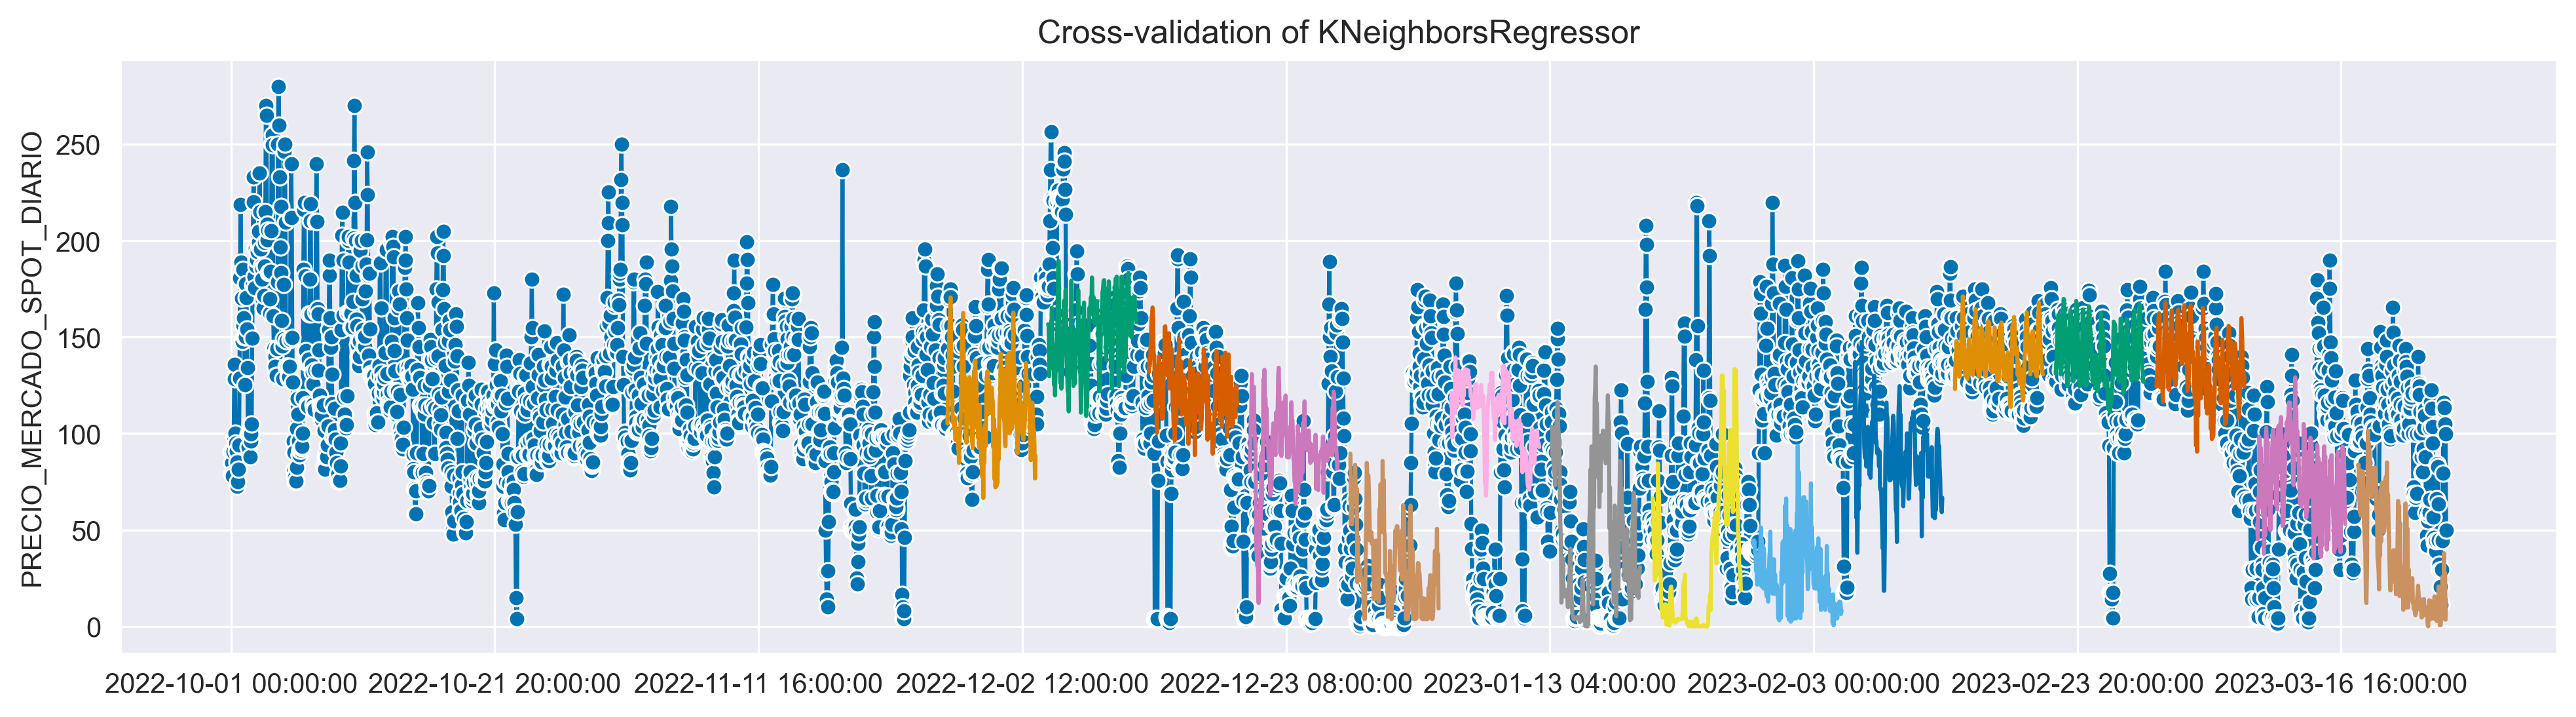

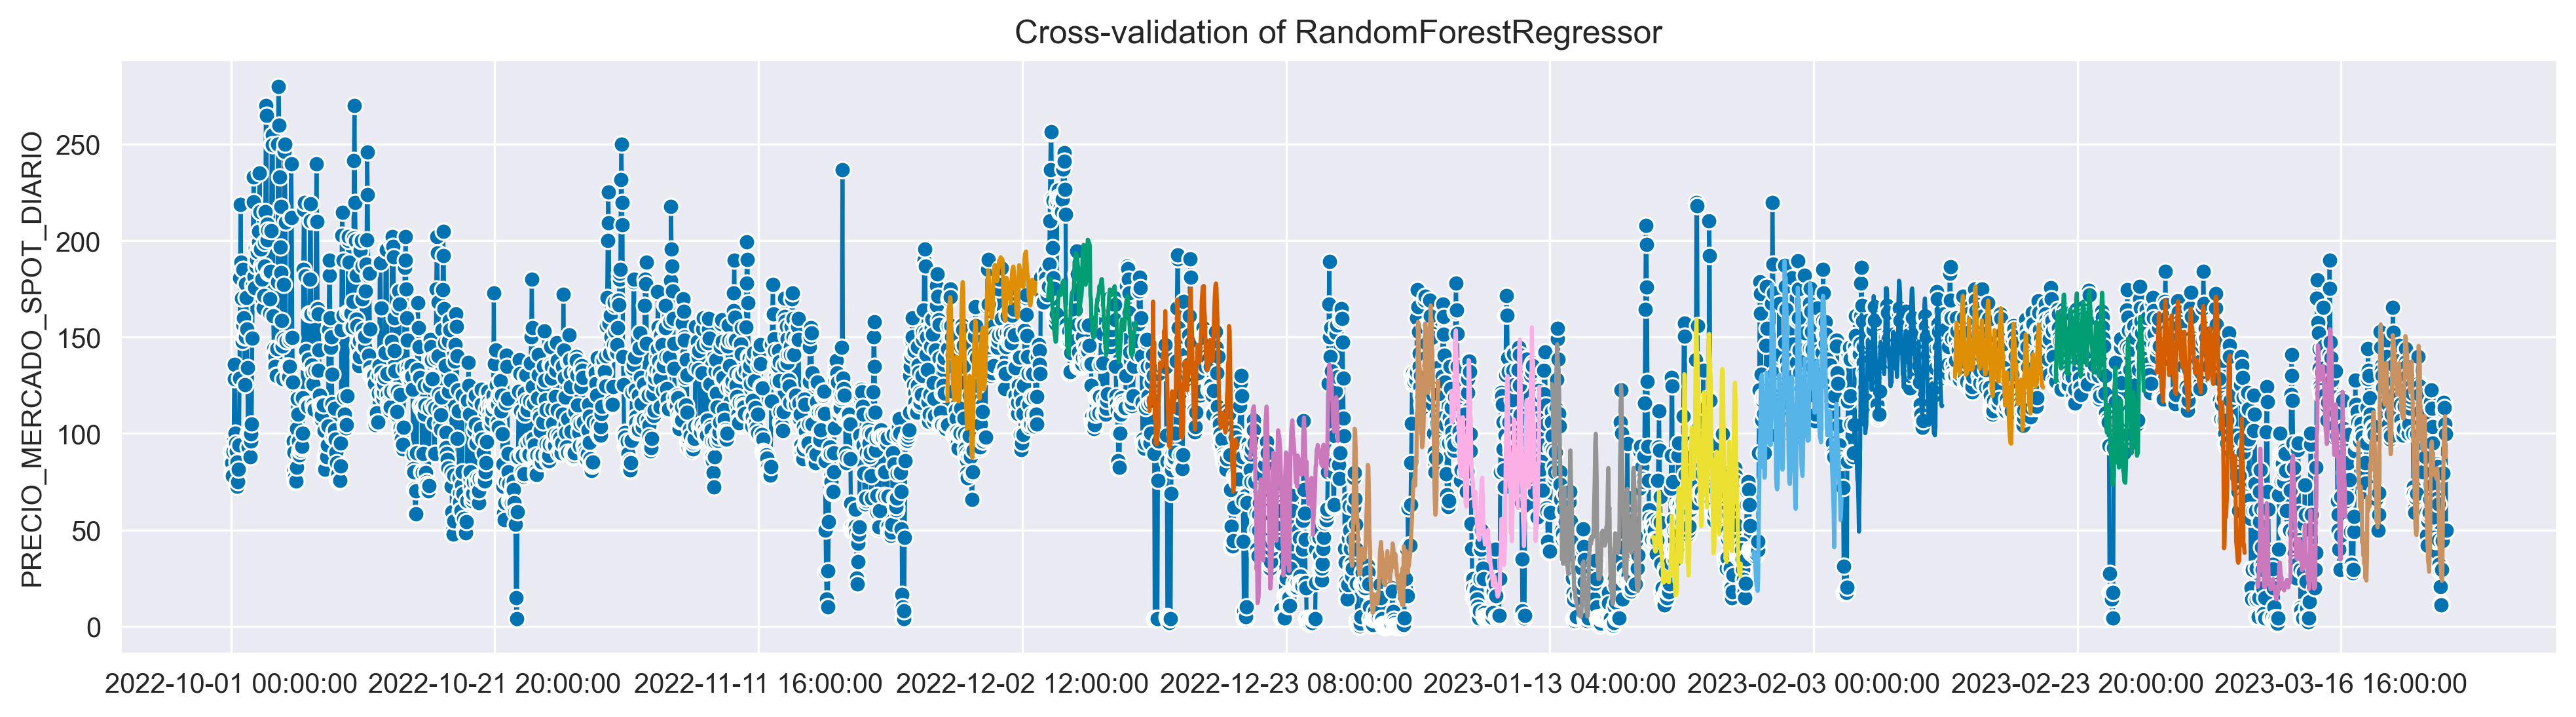

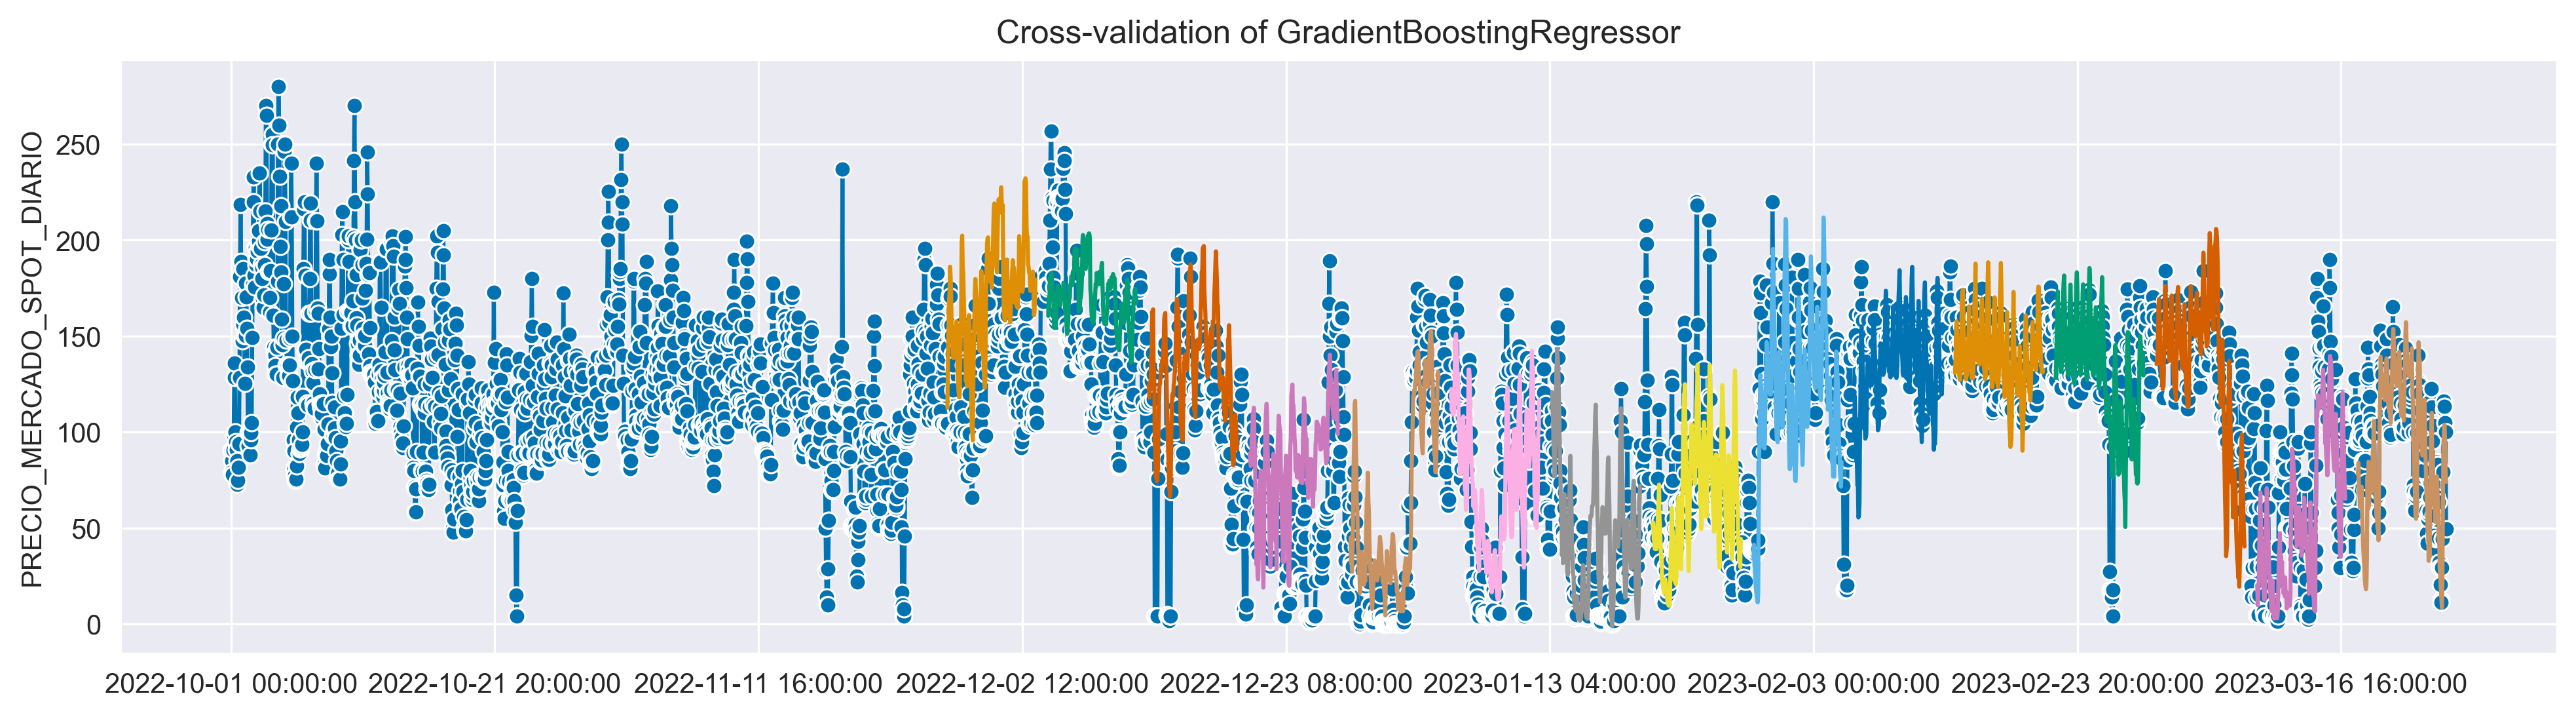

In [14]:
cv_results_df_summary = func.crossval_model_skforecast(data_train, regressor_list, regressor_str_list, initial_window_length, nb_windows, step_size, lags, date_features, forecasting_horizon)

In [15]:
cv_results_df_summary = cv_results_df_summary.sort_values("mean_mase")
cv_results_df_summary

model  mean_mase   mean_mae  modelling_time
1      RandomForestRegressor   1.964755  20.921643       98.631267
2  GradientBoostingRegressor   2.081189  22.254172       67.173223
0        KNeighborsRegressor   4.014112  42.053989      111.844110

In [16]:
save_name="hourly_post.pkl"
os.makedirs(save_path, exist_ok=True)
cv_results_df_summary.to_pickle(save_path + save_name)

In [21]:
save_name="hourly_post.pkl"
cv_results_df_summary = pd.read_pickle(save_path+save_name)

### Final model

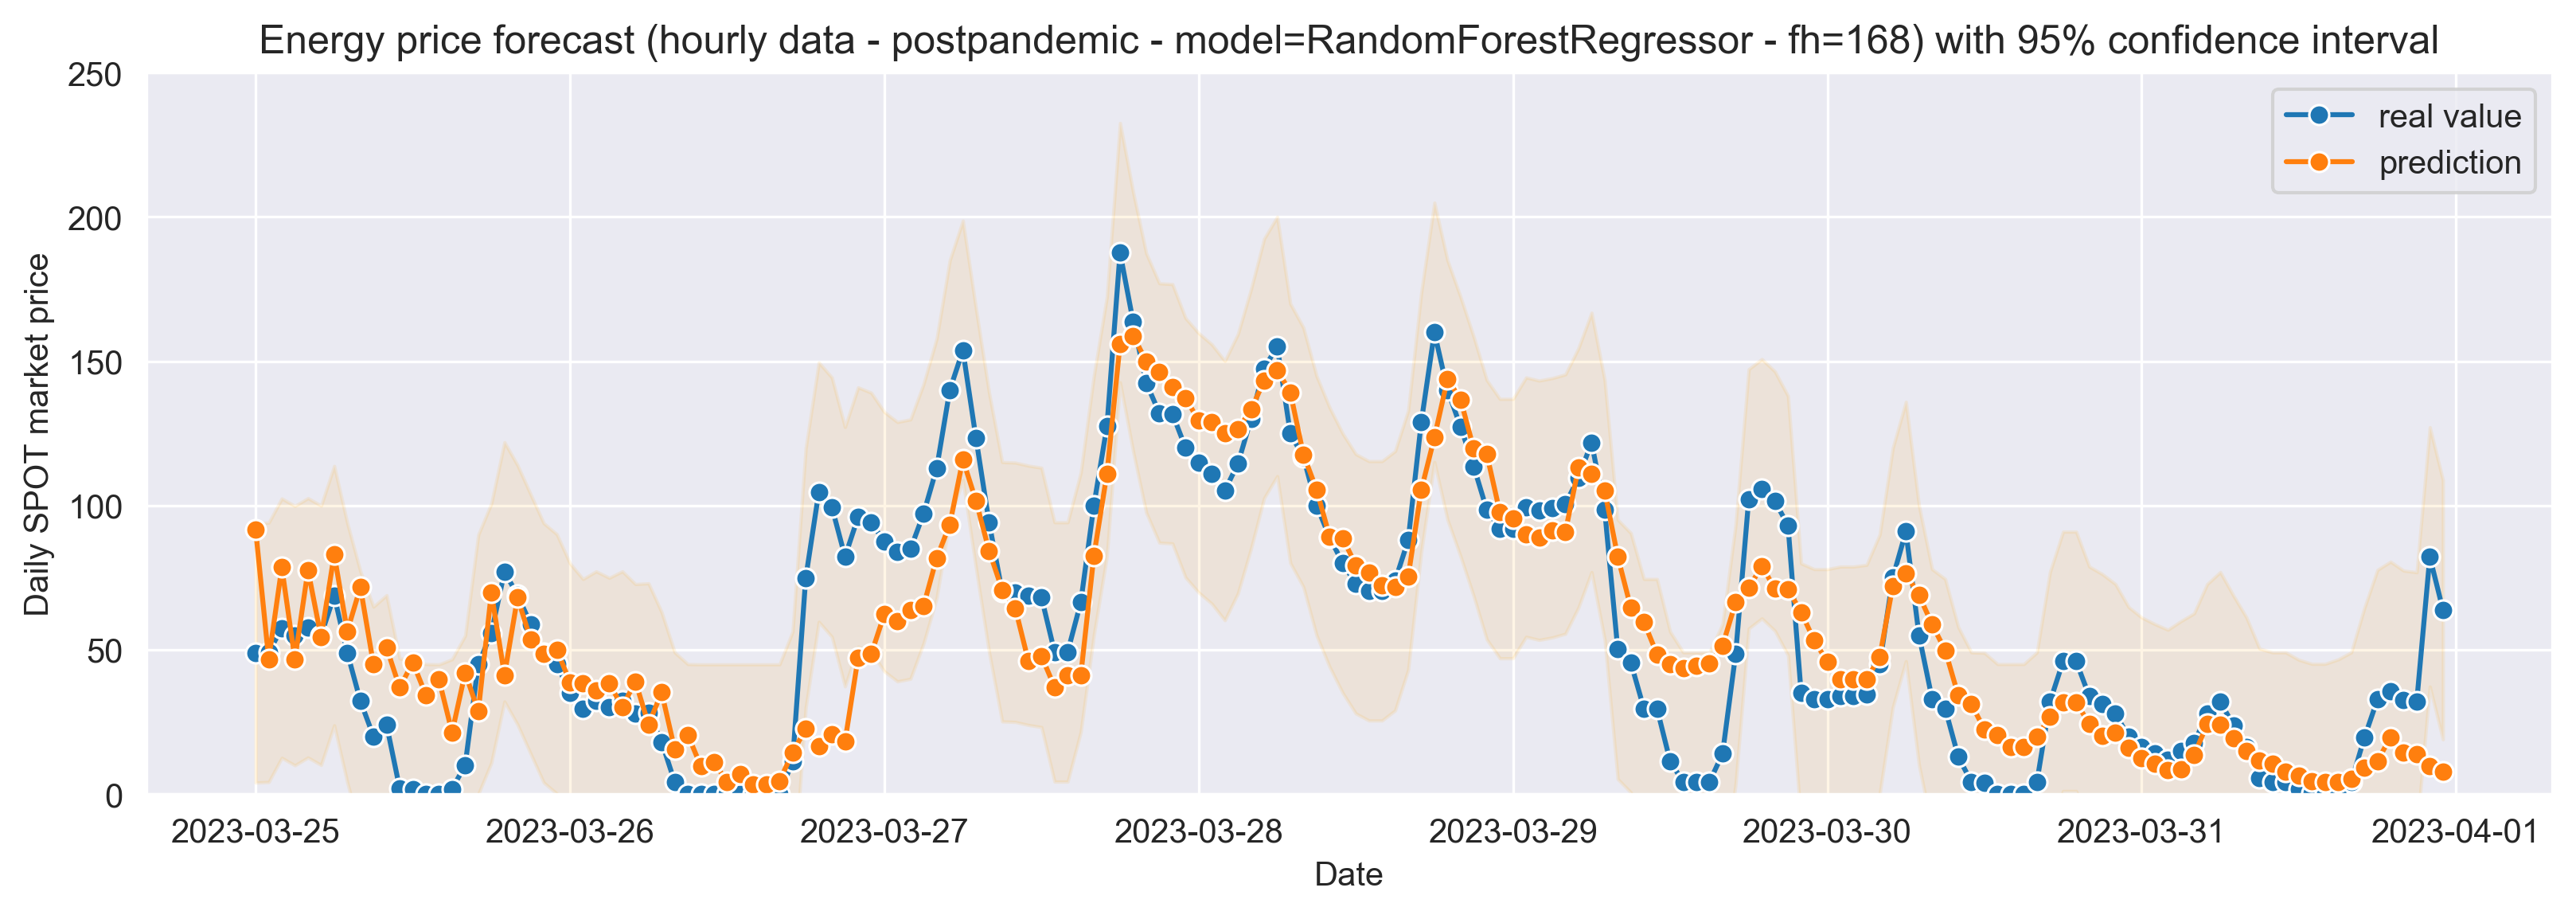

In [22]:
best_model_string = cv_results_df_summary.iloc[0, 0]
best_model = regressor_list[regressor_str_list.index(best_model_string)]
plot_lim = [0,250]
plot_title = f"Energy price forecast (hourly data - postpandemic - model={best_model_string} - fh={forecasting_horizon}) with 95% confidence interval"

func.final_model_skforecast(data_train, data_test, best_model, best_model_string, lags, date_features, forecasting_horizon, cv_results_df_summary, plot_lim, plot_title)